Processing [1/650]: ./train/eye\1-543.JPG


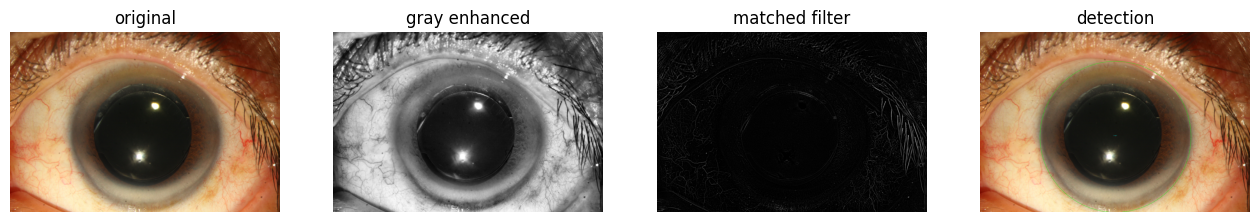

Processing [2/650]: ./train/eye\1-543.JPG


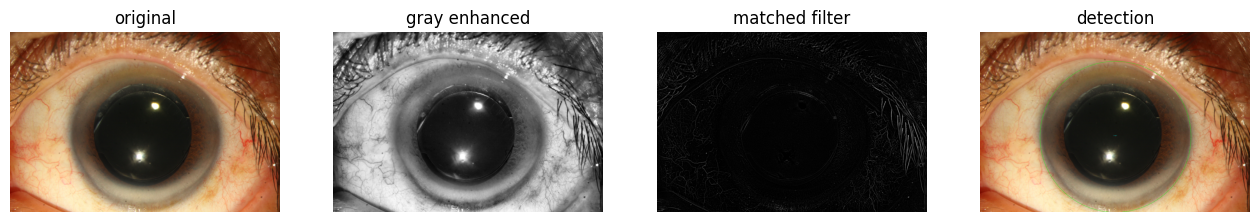

Processing [3/650]: ./train/eye\1-556.JPG


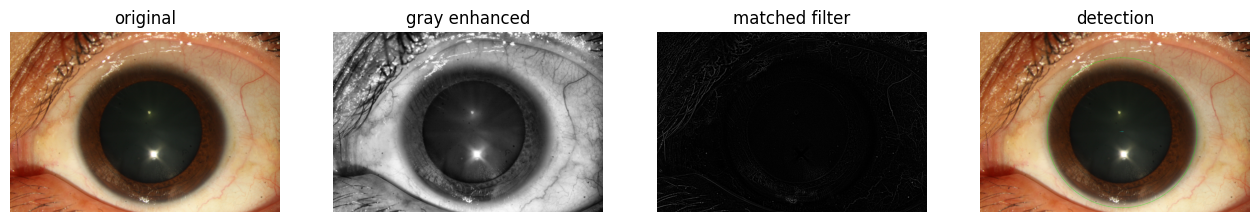

Processing [4/650]: ./train/eye\1-556.JPG
Processing [5/650]: ./train/eye\1-580.JPG


In [ ]:
# %%
"""
Iris & Eye Feature Detection pipeline (Jupyter-friendly Python script)
Case study features:
 - Human iris/pupil location
 - Hole detection via Hough Circle
 - Generalized Hough Transform (GHT) for ellipse detection
 - Spatial matched filtering to enhance dark regions
 - Object location and feature collation across images
 - Vanishing point estimation via line intersections

Instructions
 - Place your ~300 JPG images into a folder, e.g. './data/images'
 - Run cells sequentially in a Jupyter notebook
 - Required packages: numpy, opencv-contrib-python, matplotlib, scikit-image, pandas, sklearn
 - Outputs:
    - CSV file with detections: './output/detections.csv'
    - Visualization images in './output'
"""

# %%
# Imports
import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, color
import pandas as pd
from sklearn.cluster import DBSCAN

# %%
# Config
IMAGE_FOLDER = './train/eye/'     # Put your JPG images here
OUTPUT_FOLDER = './output'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
RESULTS_CSV = os.path.join(OUTPUT_FOLDER, 'detections.csv')

# Hough parameters
CANNY_LOW = 50
CANNY_HIGH = 150
HOUGH_DP = 1.5
HOUGH_MIN_DIST = 30
HOUGH_PARAM1 = 50
HOUGH_PARAM2 = 30
HOUGH_MIN_RADIUS = 10
HOUGH_MAX_RADIUS = 80

# %%
# Utilities

def imread_rgb(path):
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(path)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)


def imshow(ax, img, title=None):
    if img.ndim == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
    ax.axis('off')
    if title:
        ax.set_title(title)

# %%
# Preprocessing

def enhance_contrast_gray(gray):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(gray)


def spatial_matched_filter(gray, kernel_size=31):
    blurred = cv2.GaussianBlur(gray, (kernel_size|1, kernel_size|1), 0)
    filtered = cv2.subtract(blurred, gray)
    filtered = cv2.normalize(filtered, None, 0, 255, cv2.NORM_MINMAX)
    return filtered

# %%
# Hough circle detection

def detect_hough_circle(gray, dp=HOUGH_DP, min_dist=HOUGH_MIN_DIST,
                        param1=HOUGH_PARAM1, param2=HOUGH_PARAM2,
                        min_radius=HOUGH_MIN_RADIUS, max_radius=HOUGH_MAX_RADIUS):
    img = gray.astype(np.uint8)
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, dp, min_dist,
                               param1=param1, param2=param2,
                               minRadius=min_radius, maxRadius=max_radius)
    results = []
    if circles is not None:
        circles = np.round(circles[0, :]).astype(int)
        for (x, y, r) in circles:
            results.append({'cx': int(x), 'cy': int(y), 'r': int(r), 'score': None})
    return results

# %%
# Contour-based ellipse detection

def detect_contour_ellipses(gray, area_thresh=100):
    T = filters.threshold_otsu(gray)
    bw = (gray < T).astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ellipses = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < area_thresh or len(cnt) < 5:
            continue
        ellipse = cv2.fitEllipse(cnt)
        (cx, cy), (MA, ma), angle = ellipse
        ellipses.append({'cx': float(cx), 'cy': float(cy), 'MA': float(MA), 'ma': float(ma), 'angle': float(angle), 'area': float(area)})
    return ellipses

# %%
# Generalized Hough (optional, needs OpenCV contrib)

def detect_ght_template(img_rgb, template_rgb=None):
    try:
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        ght = cv2.createGeneralizedHoughGuil()
        if template_rgb is not None:
            tgray = cv2.cvtColor(template_rgb, cv2.COLOR_RGB2GRAY)
            tedge = cv2.Canny(tgray, 50, 150)
            ght.setTemplate(tedge)
        edge = cv2.Canny(gray, 50, 150)
        ght.setScaleThresh(50)
        detected = ght.detect(edge)
        res = []
        if detected is not None and len(detected) > 0:
            for d in detected:
                x, y, scale, score = d
                res.append({'cx': float(x), 'cy': float(y), 'scale': float(scale), 'score': float(score)})
        return res
    except Exception:
        return []

# %%
# Vanishing points

def estimate_vanishing_points(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, CANNY_LOW, CANNY_HIGH)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50, minLineLength=50, maxLineGap=10)
    if lines is None:
        return []
    lines = lines.reshape(-1,4)
    normals = []
    for x1,y1,x2,y2 in lines:
        a = y2 - y1
        b = x1 - x2
        c = x2*y1 - x1*y2
        norm = np.hypot(a,b)
        if norm==0: continue
        normals.append(np.array([a/norm,b/norm,c/norm]))
    intersections = []
    for i in range(len(normals)):
        for j in range(i+1, len(normals)):
            P = np.cross(normals[i], normals[j])
            if np.abs(P[2])<1e-6: continue
            intersections.append((P[0]/P[2], P[1]/P[2]))
    if not intersections:
        return []
    pts = np.array(intersections)
    clustering = DBSCAN(eps=50, min_samples=5).fit(pts)
    vps = []
    for lab in np.unique(clustering.labels_):
        if lab==-1: continue
        cluster_pts = pts[clustering.labels_==lab]
        mean = cluster_pts.mean(axis=0)
        vps.append({'x': float(mean[0]), 'y': float(mean[1]), 'votes': len(cluster_pts)})
    vps.sort(key=lambda x: -x['votes'])
    return vps

# %%
# Collate detections

def collate_detections(hough_results, ellipse_results, ght_results, img_shape):
    candidates = []
    H, W = img_shape[:2]
    for e in ellipse_results:
        r = max(e['MA'], e['ma'])/2
        score = 0.5 + min(1.0, e.get('area',0)/1000.0)
        candidates.append({'cx':e['cx'],'cy':e['cy'],'r':r,'score':score,'method':'ellipse'})
    for h in hough_results:
        candidates.append({'cx':h['cx'],'cy':h['cy'],'r':h['r'],'score':0.7,'method':'hough'})
    for g in ght_results:
        candidates.append({'cx':g['cx'],'cy':g['cy'],'r':g.get('scale',20)/2.0,'score':0.6+0.4*(g.get('score',0)/100.0),'method':'ght'})
    if not candidates:
        return None
    cx0, cy0 = W/2, H/2
    best, best_metric = None, -1e9
    for c in candidates:
        dist = np.hypot(c['cx']-cx0, c['cy']-cy0)
        metric = c['score']*2.0 - (dist/max(W,H))
        if metric>best_metric:
            best_metric = metric
            best = c
    return best

# %%
# Visualization

def draw_detection(img_rgb, det):
    out = img_rgb.copy()
    canvas = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
    if det:
        cx,cy,r = int(round(det['cx'])), int(round(det['cy'])), int(round(det['r']))
        cv2.circle(canvas, (cx,cy), r, (0,255,0), 2)
        cv2.circle(canvas, (cx,cy), 2, (0,0,255), -1)
        cv2.putText(canvas, f"r={r}", (max(5,cx-30), max(20,cy-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0),1)
    return cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)

# %%
# Process single image

def process_image(path, template=None, debug=False):
    img = imread_rgb(path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_enh = enhance_contrast_gray(gray)
    matched = spatial_matched_filter(gray_enh)

    hough = detect_hough_circle(matched)
    ellipses = detect_contour_ellipses(gray_enh)
    ght = detect_ght_template(img, template)

    final = collate_detections(hough, ellipses, ght, img.shape)
    vps = estimate_vanishing_points(img)

    if debug:
        fig, axs = plt.subplots(1,4,figsize=(16,4))
        imshow(axs[0], img, 'original')
        imshow(axs[1], gray_enh, 'gray enhanced')
        imshow(axs[2], matched, 'matched filter')
        imshow(axs[3], draw_detection(img, final), 'detection')
        plt.show()

    return {'path':path,'final':final,'hough':hough,'ellipses':ellipses,'ght':ght,'vps':vps}

# %%
# Batch process folder

def process_folder(folder=IMAGE_FOLDER, template_path=None, sample_debug=3, max_images=None):
    template = imread_rgb(template_path) if template_path else None
    img_paths = sorted(glob(os.path.join(folder,'*.jpg')) + glob(os.path.join(folder,'*.JPG')))
    if max_images: img_paths = img_paths[:max_images]

    rows = []
    for i, p in enumerate(img_paths):
        print(f"Processing [{i+1}/{len(img_paths)}]: {p}")
        res = process_image(p, template=template, debug=(i<sample_debug))
        final = res['final']
        row = {'image':os.path.basename(p)}
        if final:
            row.update({'cx':final['cx'],'cy':final['cy'],'r':final['r'],'method':final['method']})
        else:
            row.update({'cx':None,'cy':None,'r':None,'method':None})
        row.update({'hough_count':len(res['hough']),'ellipse_count':len(res['ellipses']),'ght_count':len(res['ght']),'vp_count':len(res['vps'])})
        rows.append(row)
        vis = draw_detection(imread_rgb(p), final)
        plt.imsave(os.path.join(OUTPUT_FOLDER, os.path.basename(p)), vis)

    df = pd.DataFrame(rows)
    df.to_csv(RESULTS_CSV, index=False)
    print(f"Saved detections.csv and visualizations to {OUTPUT_FOLDER}")
    return df

# %%
# Example usage
if __name__=='__main__':
    df = process_folder(IMAGE_FOLDER, template_path=None, sample_debug=3)
    print(df.head())


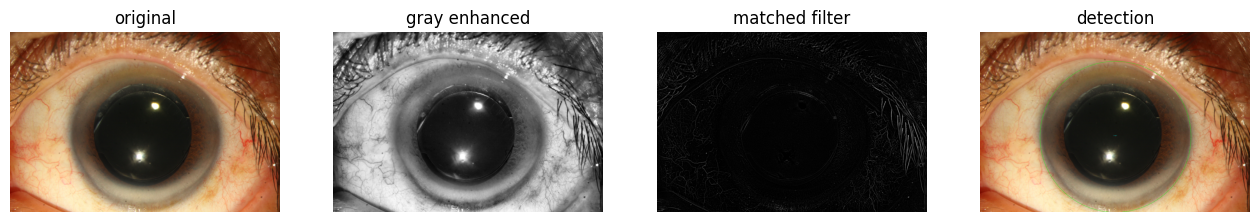

Hough detections: [{'cx': 175, 'cy': 478, 'r': 79, 'score': None}, {'cx': 83, 'cy': 509, 'r': 79, 'score': None}, {'cx': 172, 'cy': 218, 'r': 79, 'score': None}, {'cx': 3350, 'cy': 1010, 'r': 79, 'score': None}, {'cx': 178, 'cy': 578, 'r': 74, 'score': None}, {'cx': 1225, 'cy': 272, 'r': 79, 'score': None}, {'cx': 1228, 'cy': 694, 'r': 79, 'score': None}, {'cx': 1262, 'cy': 674, 'r': 79, 'score': None}, {'cx': 373, 'cy': 164, 'r': 78, 'score': None}, {'cx': 3323, 'cy': 688, 'r': 79, 'score': None}, {'cx': 1409, 'cy': 265, 'r': 79, 'score': None}, {'cx': 2311, 'cy': 803, 'r': 79, 'score': None}, {'cx': 253, 'cy': 271, 'r': 79, 'score': None}, {'cx': 1451, 'cy': 509, 'r': 79, 'score': None}, {'cx': 3062, 'cy': 164, 'r': 79, 'score': None}, {'cx': 3316, 'cy': 2189, 'r': 79, 'score': None}, {'cx': 1409, 'cy': 154, 'r': 79, 'score': None}, {'cx': 1444, 'cy': 170, 'r': 79, 'score': None}, {'cx': 3356, 'cy': 956, 'r': 79, 'score': None}, {'cx': 122, 'cy': 562, 'r': 79, 'score': None}, {'cx': 

In [3]:
sample_image = './train/eye/1-543.JPG'  # change name to a real image
res = process_image(sample_image, debug=True)
print("Hough detections:", res['hough'])
print("Ellipse detections:", res['ellipses'])
print("GHT detections:", res['ght'])
print("Final detection:", res['final'])

In [7]:
from glob import glob
import os

IMAGE_FOLDER = './train/eyes'
imgs = sorted(glob(os.path.join(IMAGE_FOLDER, '*.jpg')) + glob(os.path.join(IMAGE_FOLDER, '*.JPG')))
print("Found", len(imgs), "images")
print(imgs[:5])


Found 0 images
[]


In [10]:
import os
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\Rubini Anandhan


In [13]:
import os
print(os.listdir())  # shows folders in your current directory

if os.path.exists('./train'):
    print("Contents of ./train:", os.listdir('./train'))


['.anaconda', '.arduinoIDE', '.cache', '.conda', '.condarc', '.continuum', '.idlerc', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.matplotlib', '0.26.0', "0.26.0'", 'anaconda3', 'AppData', 'Application Data', 'BagofWords.ipynb', 'bart_finetuned_1200', 'BBC News Train.csv', 'CaseStudyIris.ipynb', 'combined_length_analysis.txt', 'Contacts', 'contacts.csv', 'Cookies', 'Desktop', 'Documents', 'document_lengths.txt', 'document_length_bins.txt', 'document_length_summary.txt', 'downloaddataset.ipynb', 'Downloads', 'Favorites', 'FIRE Summary Dataset', 'FIRE_DS_Analysis_1.ipynb', 'Indian_Legal_Ontology.owl', 'LegalBertTest.ipynb', 'legal_doc_dataset_hf.ipynb', 'legal_kg.owl', 'linearRegression.ipynb', 'Links', 'Local Settings', 'LogisticRegression.ipynb', 'logs', 'MainWork', 'miktex-console.lock', 'Music', 'My Documents', 'NER.ipynb', 'NetHood', 'nlp.ipynb', 'NLPTest2.ipynb', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{2ad838bc-efea-11ee-a54d-000d3a94eaa1}.TM.bl